**My contribution perhaps lies in the addition of "is_month_end" and "is_year_end" column, as well as the "sell_multiplier" feature according to different sinusoidal selling-over-time patterns for the 5 products.**

**Please point out any stupid mistakes. I am an absolute beginner.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


# **Data Overview**

Remove display limit.


In [2]:
pd.set_option('display.max_columns', None)

Load the dataset and have a preview.

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e1/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e1/test.csv")
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [4]:
print(train.shape)
print(test.shape)

(230130, 6)
(98550, 5)


In [5]:
print(train.dtypes)

id            int64
date         object
country      object
store        object
product      object
num_sold    float64
dtype: object


In [6]:
categorical_cols = train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"--- {col} ---")
    print(train[col].value_counts())
    print("\n")

--- date ---
date
2010-01-01    90
2014-09-05    90
2014-08-29    90
2014-08-30    90
2014-08-31    90
              ..
2012-05-03    90
2012-05-04    90
2012-05-05    90
2012-05-06    90
2016-12-31    90
Name: count, Length: 2557, dtype: int64


--- country ---
country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64


--- store ---
store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64


--- product ---
product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64




In [7]:
train.describe() # for non-object cols

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


Plot missing data heatmap.

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64


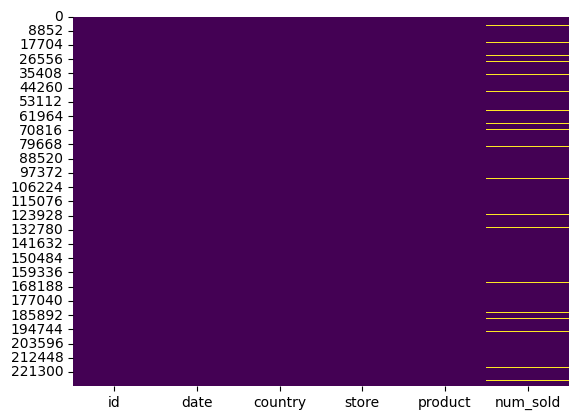

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(train.isnull(), cbar=False, cmap='viridis')
print(train.isnull().sum())

# **Preprocessing**

Pre-process the data (for object type):
- Remove all the rows with null target value
- Remove id column
- Mannually encode country, store and product

In [9]:
id_test = test["id"]
train = train.dropna()
train = train.drop("id", axis = 1)
test = test.drop("id", axis = 1)
dict_country = {"Kenya": 0, "Italy": 1, "Canada": 2, "Singapore": 3, "Finland": 4, "Norway": 5}
dict_store = {"Discount Stickers": 0, "Stickers for Less": 1, "Premium Sticker Mart": 2}
dict_product = {"Holographic Goose": 0, "Kaggle": 1, "Kaggle Tiers": 2, "Kerneler": 3, "Kerneler Dark Mode": 4}
train["country"] = train["country"].map(dict_country)
train["store"] = train["store"].map(dict_store)
train["product"] = train["product"].map(dict_product)
test["country"] = test["country"].map(dict_country)
test["store"] = test["store"].map(dict_store)
test["product"] = test["product"].map(dict_product)
print(train.head())
print(test.head())

         date  country  store  product  num_sold
1  2010-01-01        2      0        1     973.0
2  2010-01-01        2      0        2     906.0
3  2010-01-01        2      0        3     423.0
4  2010-01-01        2      0        4     491.0
5  2010-01-01        2      1        0     300.0
         date  country  store  product
0  2017-01-01        2      0        0
1  2017-01-01        2      0        1
2  2017-01-01        2      0        2
3  2017-01-01        2      0        3
4  2017-01-01        2      0        4


In [10]:
print(train.shape)
print(train.dtypes)

(221259, 5)
date         object
country       int64
store         int64
product       int64
num_sold    float64
dtype: object


Pre-process the data (for num_sold)

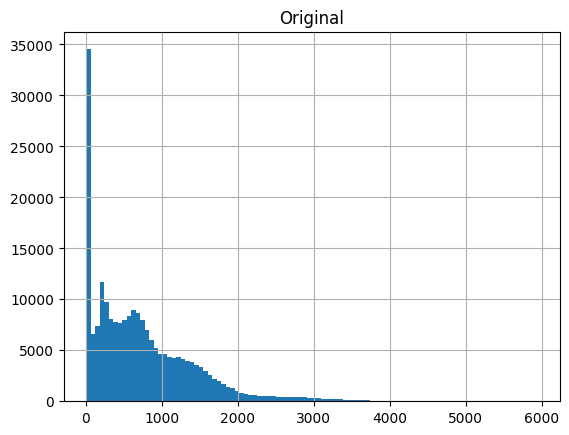

In [11]:
train["num_sold"].hist(bins=100)
plt.title("Original")
plt.show()

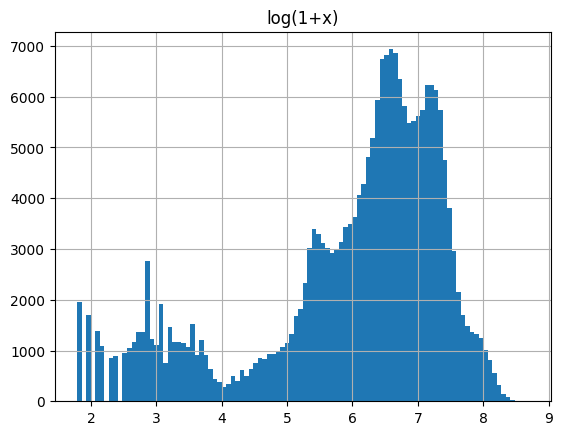

In [12]:
np.log1p(train["num_sold"].copy()).hist(bins=100)
plt.title("log(1+x)")
plt.show()

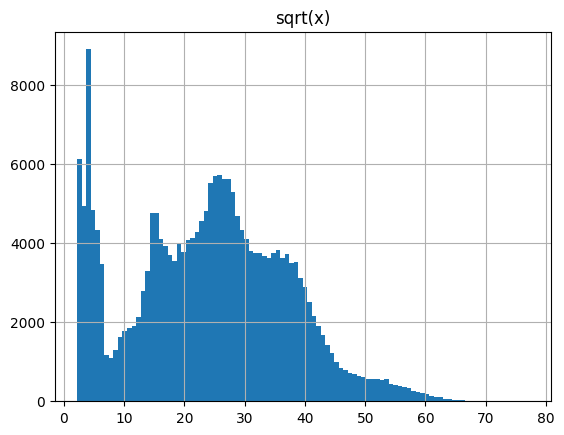

In [13]:
np.sqrt(train["num_sold"].copy()).hist(bins=100)
plt.title("sqrt(x)")
plt.show()

In [14]:
train["log_num_sold"] = np.log1p(train["num_sold"])

Pre-process the data (for date):
- Split year, month, date
- Create another feature "time from 2009-12-31 in days"

In [15]:
train["date"] = pd.to_datetime(train["date"])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day

reference_date = pd.Timestamp("2009-12-31")
train['time_from_2009_12_31'] = (train['date'] - reference_date).dt.days

In [16]:
test["date"] = pd.to_datetime(test["date"])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

reference_date = pd.Timestamp("2009-12-31")
test['time_from_2009_12_31'] = (test['date'] - reference_date).dt.days

# **Feature engineering**

In [17]:
top_50_peaks = train.nlargest(50, 'num_sold')
print(top_50_peaks)

             date  country  store  product  num_sold  log_num_sold  year  \
98531  2012-12-30        5      2        1    5939.0      8.689464  2012   
164051 2014-12-28        5      2        1    5643.0      8.638348  2014   
131291 2013-12-29        5      2        1    5455.0      8.604471  2013   
33011  2011-01-02        5      2        1    5260.0      8.568076  2011   
65771  2012-01-01        5      2        1    5240.0      8.564268  2012   
111761 2013-05-26        5      2        1    5174.0      8.551595  2013   
45611  2011-05-22        5      2        1    5079.0      8.533067  2011   
46871  2011-06-05        5      2        1    4995.0      8.516393  2011   
111671 2013-05-25        5      2        1    4971.0      8.511577  2013   
131292 2013-12-29        5      2        2    4958.0      8.508959  2013   
43541  2011-04-29        5      2        1    4955.0      8.508354  2011   
106721 2013-03-31        5      2        1    4917.0      8.500657  2013   
43721  2011-

From this table, it is observed that if time is at the end/start of each month or year, the number of stickers sold will be significantly larger. "is_end_start_year" and "is_end_start_month" features will be added.

is_end_start_month: true if day ∈ {27, 28, 29, 30, 31, 1, 2, 3, 4}\
is_end_start_year: true if month = 12 and day ∈ {29, 30, 31} or month = 1 and day ∈ {1, 2, 3}

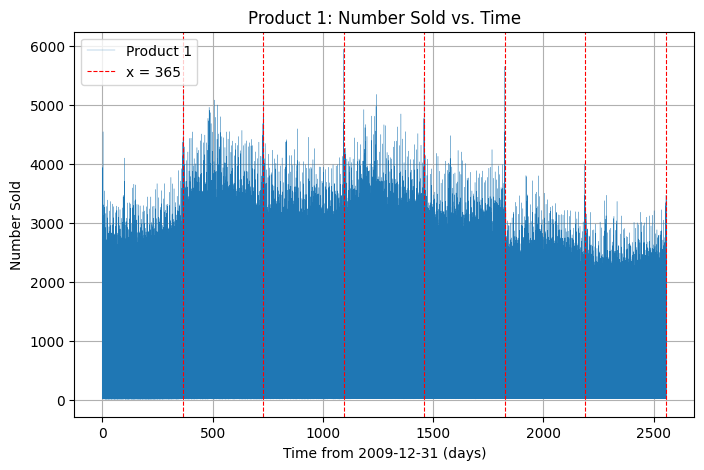

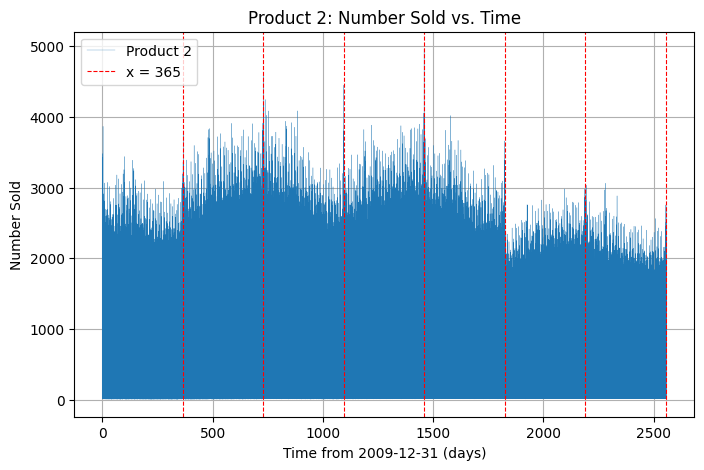

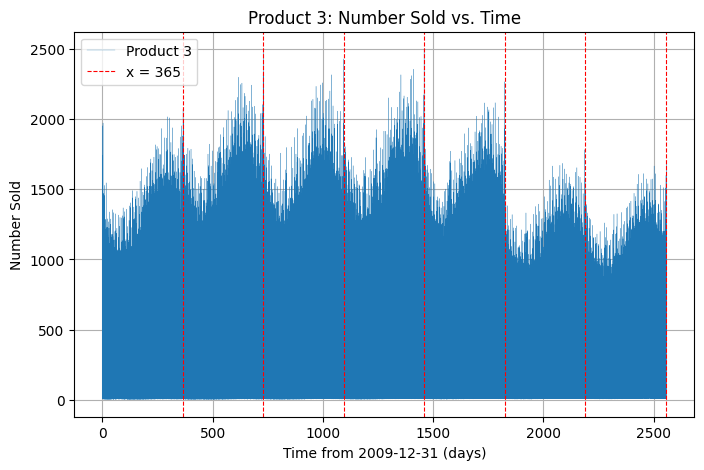

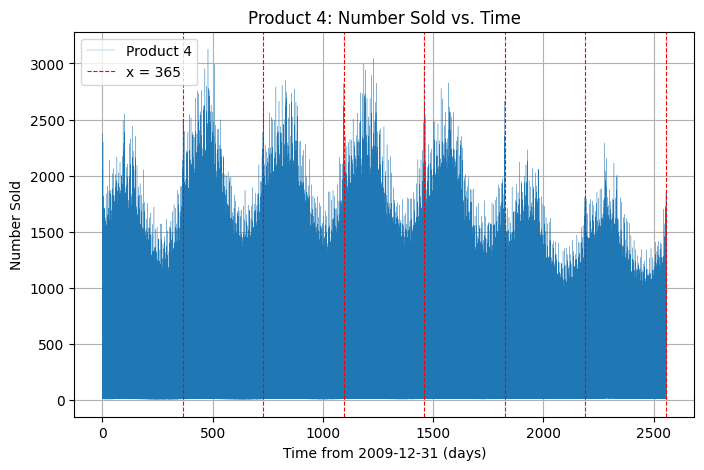

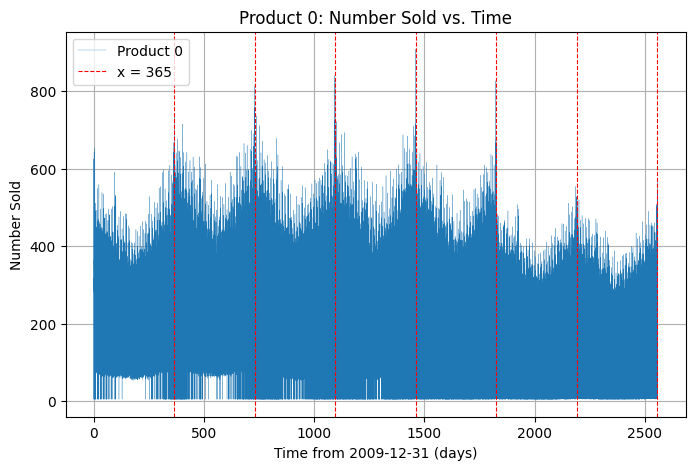

In [18]:
for product in train['product'].unique():
    subset = train[train['product'] == product]
    plt.figure(figsize=(8, 5))
    
    # Plot the data
    plt.plot(
        subset['time_from_2009_12_31'],
        subset['num_sold'],
        label=f'Product {product}',
        linewidth=0.2
    )

    for i in range(1, 8):  # Loop to create lines for 365, 365*2, ..., 365*4
        plt.axvline(x=365 * i, color='red', linestyle='--', linewidth=0.8, label=f'x = {365 * i}' if i == 1 else None)
        
    # Add title, labels, and legend
    plt.title(f'Product {product}: Number Sold vs. Time')
    plt.xlabel('Time from 2009-12-31 (days)')
    plt.ylabel('Number Sold')
    plt.legend()
    plt.grid(True)
    plt.show()

The wave-like sells pattern is omnipresent for all the five products. A new feature "sell_multiplier" is introduced. The equations are obtained as follows (t is time from 2009-12-31, k is the multiplier):

For product 0: k0 = 0.2·cos(2πt/365)\
For product 1: k1 = 0.8·sin(2π(t - 365)/730)\
For product 2: k2 = 0.8·sin(2π(t + 183)/730)\
For product 3: k3 = -0.8sin(2πt/365)\
For product 4: k4 = 0.9sin(2πt/365)

In [19]:
import math

def calculate_k(row):
    t = row['time_from_2009_12_31']
    if row['product'] == 0:
        return 0.2 * np.cos(2 * math.pi * t / 365)
    elif row['product'] == 1:
        return 0.8 * np.sin(2 * math.pi * (t - 365) / 730)
    elif row['product'] == 2:
        return 0.8 * np.sin(2 * math.pi * (t + 183) / 730)
    elif row['product'] == 3:
        return -0.8 * np.sin(2 * math.pi * t / 365)
    elif row['product'] == 4:
        return 0.9 * np.sin(2 * math.pi * t / 365)
    else:
        return 0

In [20]:
train['sell_multiplier'] = train.apply(calculate_k, axis=1)
train['is_month_end'] = train['day'].isin({27, 28, 29, 30, 31, 1, 2, 3, 4}).astype(int)
train['is_end_start_year'] = (
    ((train['month'] == 12) & (train['day'].isin({29, 30, 31}))) |  # End of the year
    ((train['month'] == 1) & (train['day'].isin({1, 2, 3})))       # Start of the year
).astype(int)

test['sell_multiplier'] = test.apply(calculate_k, axis=1)
test['is_month_end'] = test['day'].isin({27, 28, 29, 30, 31, 1, 2, 3, 4}).astype(int)
test['is_end_start_year'] = (
    ((test['month'] == 12) & (test['day'].isin({29, 30, 31}))) |  # End of the year
    ((test['month'] == 1) & (test['day'].isin({1, 2, 3})))       # Start of the year
).astype(int)

Drop columns "date", "month", "year", "day", "num_sold". Scale "time_from_2009_12_31".

In [21]:
train = train.drop(columns = ["date", "year", "month", "day", "num_sold"])
test = test.drop(columns = ["date", "year", "month", "day"])


train["time_from_2009_12_31"] = train["time_from_2009_12_31"]
test["time_from_2009_12_31"] = test["time_from_2009_12_31"]


print(train.dtypes)
print(test.dtypes)

country                   int64
store                     int64
product                   int64
log_num_sold            float64
time_from_2009_12_31      int64
sell_multiplier         float64
is_month_end              int64
is_end_start_year         int64
dtype: object
country                   int64
store                     int64
product                   int64
time_from_2009_12_31      int64
sell_multiplier         float64
is_month_end              int64
is_end_start_year         int64
dtype: object


# **Training**

In [22]:
# experiment with feature selection
def select_important_features(df, columns = ['country', 'store', 'product', 'is_month_end', 'sell_multiplier', 'is_end_start_year', 'time_from_2009_12_31']):
    return df[columns]

In [23]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


y = train["log_num_sold"]
X = select_important_features(train)

X = X[sorted(X.columns)]
test = test[sorted(test.columns)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=114514)


model = xgb.XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=7,
    random_state=114514,
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 0.0932


# **Tuning**

In [24]:
#import optuna
#import xgboost as xgb
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import mean_squared_error
#import numpy as np
#
## Define the objective function for Optuna
#def objective(trial):
#    param = {
#        'n_estimators': trial.suggest_int('n_estimators', 200, 300),
#        'learning_rate': trial.suggest_float('learning_rate', 0.07, 0.2),
#        'max_depth': 7,
#        'random_state': 114514
#    }
#
#    # Split data
#    y = train["log_num_sold"]
#    X = select_important_features(train)
#
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=114514)
#
#    # Create and train the model
#    model = xgb.XGBRegressor(**param)
#    model.fit(X_train, y_train)

#    # Predict and calculate RMSE
#    y_pred = model.predict(X_test)
#    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#    print(f"Trial {trial.number}: RMSE = {rmse:.4f}")
#    return rmse
#
## Create the Optuna study
#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=50)
#
## Print the best parameters and score
#print("Best Parameters:", study.best_params)
#print(f"Best RMSE: {study.best_value:.4f}")


# **Prepare to Submit**

In [25]:
prediction = np.exp(model.predict(test)) - 1
print(prediction)

[ 147.17494  852.4782   649.5006  ... 2547.386   1176.6343  1467.8729 ]


In [26]:
submission = pd.DataFrame({'id': id_test, 'num_sold': prediction})
submission.to_csv("submission.csv", index=False)